# smallで分析を行う
## 調べること
- 各ファイルがどんな役割を
- データのサイズ
- どんなカラムがあるか
  - カラムの内容
  - 離散 vs 連続
  - numeric vs categorical
- ユーザ数
- 記事の本数は？
- アクション数の総計は？
- アクションの種類
- 各ユーザの累計アクセス数は？
- 各ユーザの継続率は？
- 日数情報があれば。
  - どんなカテゴリの記事が人気か？

### Dataset
- behaviors.tsv: The behaviors.tsv file contains the impression logs and users’ news click histories. It has five columns divided by the tab symbol:
- news.tsv: ニュース記事の情報
- entity_embedding.vec: ナレッジグラフから抽出したニュースに含まれるエンティティの埋め込み
- relation_embedding.vec: ナレッジグラフから抽出したエンティティ間の関係の埋め込み

In [53]:
import polars as pl
from src.const.path import DATASET_DIR
from matplotlib import pyplot as plt


In [32]:
MIND_DATASET_DIR = DATASET_DIR / "mind"
MIND_SMALL_DATASET_DIR = MIND_DATASET_DIR / "small"
MIND_LARGE_DATASET_DIR = MIND_DATASET_DIR / "large"
MIND_SMALL_DATASET_TRAIN_DIR = MIND_SMALL_DATASET_DIR / "train"
MIND_LARGE_DATASET_TRAIN_DIR = MIND_LARGE_DATASET_DIR / "train"


In [33]:
behavior_df = pl.read_csv(
    MIND_LARGE_DATASET_TRAIN_DIR / "behaviors.tsv", separator="\t", encoding="utf8-lossy", has_header=False
)
news_df = pl.read_csv(
    MIND_LARGE_DATASET_TRAIN_DIR / "news.tsv", separator="\t", encoding="utf8-lossy", has_header=False
)
entity_embedding_df = pl.read_csv(
    MIND_LARGE_DATASET_TRAIN_DIR / "entity_embedding.vec", separator="\t", encoding="utf8-lossy", has_header=False
)
relation_embedding_df = pl.read_csv(
    MIND_LARGE_DATASET_TRAIN_DIR / "relation_embedding.vec", separator="\t", encoding="utf8-lossy", has_header=False
)


## Column
### behaviors.tsv
- Impression ID:  Impression ID
- User ID: User ID
- Time: Timestamp of Impression
- History: News IDs
- Impressions: List of news displayed in this impression and user’s click behaviors on them (1 for click and 0 for non-click).
<!-- どうやってクリックしたNews IDのリストを抽出ているんだろうか... -->
<!-- 世の中に落ちている実装とか見ながらだな -->

### news.tsv

- News ID: Id of news
- Category: Category News
- Subcategory: subcategory of news
- Title: News Title
- Abstract: News Abstract
- URL: URL
- Title Entities (entities contained in the title of this news): タイトル内に含まれる知識グラフのノード群
- Abstract Entities (entities contained in the abstract of this news): Abstract内に含まれる知識グラフのノード群


### entity_embedding.vec & relation_embedding.vec

- 100次元で表現されたentityとrelationのEmbedding
- WikiDataという知識グラフからTransEという手法を用いて学習.


In [34]:
news_df = news_df.rename(
    {
        "column_1": "news_id",
        "column_2": "category",
        "column_3": "subcategory",
        "column_4": "title",
        "column_5": "abstract",
        "column_6": "url",
        "column_7": "title_entities",
        "column_8": "abstract_entities",
    }
)
behavior_df = behavior_df.rename(
    {
        "column_1": "impression_id",
        "column_2": "user_id",
        "column_3": "time",
        "column_4": "history",
        "column_5": "impressions",
    }
)


In [35]:
news_df.head()


news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
str,str,str,str,str,str,str,str
"""N88753""","""lifestyle""","""lifestyleroyal…","""The Brands Que…","""Shop the noteb…","""https://assets…","""[{""Label"": ""Pr…","""[]"""
"""N45436""","""news""","""newsscienceand…","""Walmart Slashe…","""Apple's new iP…","""https://assets…","""[{""Label"": ""IP…","""[{""Label"": ""IP…"
"""N23144""","""health""","""weightloss""","""50 Worst Habit…","""These seemingl…","""https://assets…","""[{""Label"": ""Ad…","""[{""Label"": ""Ad…"
"""N86255""","""health""","""medical""","""Dispose of unw…",null,"""https://assets…","""[{""Label"": ""Dr…","""[]"""
"""N93187""","""news""","""newsworld""","""The Cost of Tr…","""Lt. Ivan Molch…","""https://assets…","""[]""","""[{""Label"": ""Uk…"


In [36]:
behavior_df.head()


impression_id,user_id,time,history,impressions
i64,str,str,str,str
1,"""U87243""","""11/10/2019 11:…","""N8668 N39081 N…","""N78206-0 N2636…"
2,"""U598644""","""11/12/2019 1:4…","""N56056 N8726 N…","""N47996-0 N8271…"
3,"""U532401""","""11/13/2019 11:…","""N128643 N87446…","""N103852-0 N534…"
4,"""U593596""","""11/12/2019 12:…","""N31043 N39592 …","""N38902-0 N7643…"
5,"""U239687""","""11/14/2019 8:0…","""N65250 N122359…","""N76209-0 N4884…"


In [37]:
news_df.glimpse()


Rows: 101282
Columns: 8
$ news_id           <str> N88753, N45436, N23144, N86255, N93187, N75236, N99744, N5771, N124534, N51947
$ category          <str> lifestyle, news, health, health, news, health, health, health, sports, news
$ subcategory       <str> lifestyleroyals, newsscienceandtechnology, weightloss, medical, newsworld, voices, medical, cardio, football_nfl, newsscienceandtechnology
$ title             <str> The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By, Walmart Slashes Prices on Last-Generation iPads, 50 Worst Habits For Belly Fat, Dispose of unwanted prescription drugs during the DEA's Take Back Day, The Cost of Trump's Aid Freeze in the Trenches of Ukraine's War, I Was An NBA Wife. Here's How It Affected My Mental Health., How to Get Rid of Skin Tags, According to a Dermatologist, Check Houston traffic map for current road conditions, Should NFL be able to fine players for criticizing officiating?, How to record your screen on Windows, macOS, iOS o

In [41]:
behavior_df.glimpse()


Rows: 2232748
Columns: 5
$ impression_id <i64> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
$ user_id       <str> U87243, U598644, U532401, U593596, U239687, U521853, U687515, U192112, U530668, U290933
$ time          <str> 11/10/2019 11:30:54 AM, 11/12/2019 1:45:29 PM, 11/13/2019 11:23:03 AM, 11/12/2019 12:24:09 PM, 11/14/2019 8:03:01 PM, 11/11/2019 10:47:31 AM, 11/13/2019 5:31:06 AM, 11/11/2019 9:06:04 AM, 11/11/2019 2:10:15 PM, 11/10/2019 11:54:34 AM
$ history       <str> N8668 N39081 N65259 N79529 N73408 N43615 N29379 N32031 N110232 N101921 N12614 N129591 N105760 N60457 N1229 N64932, N56056 N8726 N70353 N67998 N83823 N111108 N107520 N53168 N78756 N106411 N81824 N85691 N16173 N24446 N120926 N19175 N126159 N26373 N72369 N73228 N111873 N88638 N29503 N31055, N128643 N87446 N122948 N9375 N82348 N129412 N54948 N36094 N44660 N3948 N21332 N81364 N83062 N87788 N59280 N31323, N31043 N39592 N4104 N8223 N114581 N92747 N12070 N61321 N40052 N50176 N101119 N76810 N37509, N65250 N122359 N71723 N53796 N41663 N414

In [46]:
news_df.describe()


describe,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
str,str,str,str,str,str,str,str,str
"""count""","""101282""","""101282""","""101282""","""101282""","""101282""","""101282""","""101282""","""101282"""
"""null_count""","""0""","""0""","""0""","""0""","""5403""","""0""","""0""","""3"""
"""mean""",null,null,null,null,null,null,null,null
"""std""",null,null,null,null,null,null,null,null
"""min""","""N1""","""autos""","""ads-latingramm…","""#10 Volleyball…","""#4 will make y…","""[{""Label"": ""An…","""[]""","""[]"""
"""max""","""N99999""","""weather""","""yearinoffbeatg…","""﻿﻿Princess Cha…","""﻿UPDATE @ 9:40…","""https://assets…","""[{""Label"": ""\u…","""[{""Label"": ""\u…"
"""median""",null,null,null,null,null,null,null,null
"""25%""",null,null,null,null,null,null,null,null
"""75%""",null,null,null,null,null,null,null,null


In [52]:
# ユーザごとのアクション数
# 各ユーザの継続率
# どんなカテゴリの記事が人気か？

user_impression_cnt = behavior_df.groupby("user_id").count().sort("count", descending=True)
# 分布をグラフにしても良さそう。

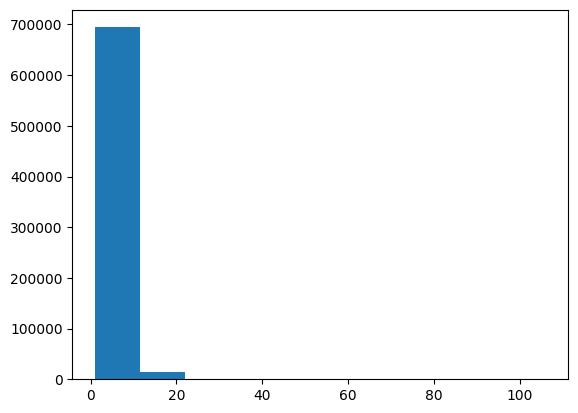

In [54]:
bin_width = 10
plt.hist(user_impression_cnt["count"], bins=bin_width)
plt.show()

# ほとんどが 0 ~ 10だなー。

In [55]:
news_df.head()


news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
str,str,str,str,str,str,str,str
"""N88753""","""lifestyle""","""lifestyleroyal…","""The Brands Que…","""Shop the noteb…","""https://assets…","""[{""Label"": ""Pr…","""[]"""
"""N45436""","""news""","""newsscienceand…","""Walmart Slashe…","""Apple's new iP…","""https://assets…","""[{""Label"": ""IP…","""[{""Label"": ""IP…"
"""N23144""","""health""","""weightloss""","""50 Worst Habit…","""These seemingl…","""https://assets…","""[{""Label"": ""Ad…","""[{""Label"": ""Ad…"
"""N86255""","""health""","""medical""","""Dispose of unw…",null,"""https://assets…","""[{""Label"": ""Dr…","""[]"""
"""N93187""","""news""","""newsworld""","""The Cost of Tr…","""Lt. Ivan Molch…","""https://assets…","""[]""","""[{""Label"": ""Uk…"


In [59]:
behavior_df["impressions"][0].split(" ")
# Clicked 

['N78206-0',
 'N26368-0',
 'N7578-0',
 'N58592-0',
 'N19858-0',
 'N58258-0',
 'N18478-0',
 'N2591-0',
 'N97778-0',
 'N32954-0',
 'N94157-1',
 'N39404-0',
 'N108809-0',
 'N78699-1',
 'N71090-1',
 'N40282-0',
 'N31174-1',
 'N37924-0',
 'N27822-0']